In [1]:
import collections
import os
import pathlib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
log_files_directory = 'SIP_logs/'
sip_messages_list_pickle = 'SIP_logs/pickle.dat'
rx_tx_req_resp = ['Rx<-', 'Tx->']
sip_msg = '*****SIP message*****\n'
sip_messages_delimiter = '_________________________________________\n'
sip_20 = 'SIP/2.0 '
callid = ['call-id:', 'i:'] # Full version (converted to lowercase) and compact version of Call-ID 
cseq = ['cseq:'] #CSeq converted to lowercase
sip_df_columns = ['Timestamp', 'Call-ID', 'CSeq_num', 'CSeq_meth',
                  'Direction', 'SIP method', 'Src Dst IP']

In [3]:
########################################################################################################

### Create SIP messages list from large text log file
### Save the file to pickle
### Full list is necessary for further extraction of
### different SIP header lines

def sip_messages_list(log_files_directory, sip_messages_list_pickle):
    
    # Delete the pickle file if exists
    try:
        os.remove(sip_messages_list_pickle)
    except OSError:
        pass
    
    def find_file_number(log_files_unsorted):
        l = []
        for s in log_files_unsorted:
            l.append(int(s.split('_', 2)[2].split('.')[0]))

        filenames_dict = dict(zip(l, log_files_unsorted))
        return filenames_dict
    
    # Create ordered dictionary, keys = numbers in SIP log filename, filenames - values
    lf_dir = pathlib.Path(log_files_directory)
    lf_unsorted_list = [str(p) for p in lf_dir.iterdir() if p.is_file()]
    filenames_dict = find_file_number(lf_unsorted_list)
    lf_sorted_dict = collections.OrderedDict(sorted(filenames_dict.items()))
    
    sip_messages_list = []
        
    for log_file in lf_sorted_dict.values():
        
        single_message_dict = {}
        single_message_list = []
        d = False
        
        # Read large text file line by line
        with open(log_file, 'r', errors='ignore') as input_file:

            for line in input_file:
                k = line.split('|')[1]
                s = line.split('|')[4]

                # Ignore the first delimiter
                if s == sip_msg:
                    continue

                elif s.split(' ')[0] in rx_tx_req_resp:
                    # Next lines a SIP message lines
                    single_message_list.append(line.split('|')[4].split('\n')[0])
                    # All the next lines until the delimiter are SIP message lines
                    d = True

                elif (s not in sip_messages_delimiter) & (d is True):
                    # The line is not the delimiter, it's a part of a SIP message
                    # add the line to single_message_list
                    single_message_list.append(s.split('\n')[0])


                elif (s not in sip_messages_delimiter) & (d is False):
                    continue

                elif (s in sip_messages_delimiter) & (d is True):

                    # Delimiter indicates the end of single SIP message
                    # Add the message to single_message_dict
                    single_message_dict[k] =  single_message_list
                    sip_messages_list.append(single_message_dict)

                    # Clear single_message_list, single_message_dict 
                    single_message_list = []
                    single_message_dict = {}
                    d = False

                else:
                    continue
            # Dump sip_messages_list to pickle
            with open(sip_messages_list_pickle, "wb") as f:
                pickle.dump(sip_messages_list, f)

########################################################################################################

### Extract year-month-day from log file names

def ymd_from_filenames(log_files_directory):
    lf_dir = pathlib.Path(log_files_directory)
    lf = [p for p in lf_dir.iterdir() if p.is_file()]
    log_files = [q for q in lf if 'SIP_' in str(q)]
    log_files = [str(r).split('_')[1] for r in log_files]
    if len(set(log_files)) > 1:
        print('Multiple Y-M-D combinations in log file names!!!')
        return -1
    else:
        ymd = set(log_files).pop().split('-')
        # Convert to str to int
        ymd = list(map(int, ymd))
    return ymd

#######################################################################################################

### Create SIP dataframe

def sip_dataframe(sip_messages_list_pickle):
    
    row_list = []
    # Read from the list saved to the pickle
    with open(sip_messages_list_pickle, "rb") as sml_pickle:
        for sm in pickle.load(sml_pickle):
            for k, v in sm.items():
                
                # Extract direction - Rx or Tx
                if 'Rx' in v[0].split(' ')[0]:
                    direction = 'Rx'
                else:
                    direction = 'Tx'
                    
                src_dst_ip = v[0].split(' ')[3].split(':')[1]
                
                if sip_20 in v[2]:
                    sip_meth = v[2].split(sip_20)[1]
                else:
                    sip_meth = v[2].split(' ')[0]
                    
                # Call-ID value ('Call-Id', 'Call-ID' etc are converted to lowercase)
                cid = [s.split(' ')[1] for s in v if any(s.split(' ')[0].lower() in x
                                                         for x in callid)]
                
                # CSeq number and method ('CSeq', 'Cseq' etc are converted to lowercase)
                cs = [s for s in v if any(s.split(' ')[0].lower() in x for x in cseq)]
                cseq_num = cs[0].split(' ')[1]
                cseq_meth = cs[0].split(' ')[2]
                
                row_list.append([k, cid[0], cseq_num, cseq_meth,
                                 direction, sip_meth, src_dst_ip])

        df = pd.DataFrame(row_list)
        df.columns = sip_df_columns        
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%H:%M:%S.%f', utc=True)
        
        # Set year-month-day extracted from log file names
        ymd = ymd_from_filenames(log_files_directory)
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=ymd[0],
                                                                    month = ymd[1],
                                                                    day = ymd[2]))
    
    return df

########################################################################################################

### Extract INVITE-200OK transactions 
def invite_200OK_trans(df):
    inv_200OK_list = ['180 Ringing', '183 Session Progress', '202 Accepted',
         '480 Temporarily Unavailable', '481 Call Leg/Transaction Does Not Exist',
         '481 Call/Transaction Does Not Exist', '486 Busy Here',
         '487 Request Cancelled', '487 Request Terminated', '503 Service Unavailable',
         'CANCEL', 'INFO', 'NOTIFY', 'OPTIONS', 'REFER', 'UPDATE']
    
    df_new = df.set_index(['Call-ID', 'CSeq_num'])
    index = pd.MultiIndex.from_product([[], []])
    for i in inv_200OK_list:
        index = index.append(df_new.index[df['SIP method'] == i])

    df_inv_200OK = df_new.drop(index)
    df_inv_200OK = df_inv_200OK[(df_inv_200OK['CSeq_meth'] == 'INVITE') & 
              ((df_inv_200OK['SIP method'] == 'INVITE') | 
               (df_inv_200OK['SIP method'] == '200 OK'))]
    df_inv_200OK = df_inv_200OK.reset_index()
    return df_inv_200OK

##########################################################################################################

### Extract INFO-200OK transactions
def info_200OK_trans(df):
    inf_200OK_list = ['180 Ringing', '183 Session Progress', '202 Accepted',
         '480 Temporarily Unavailable', '481 Call Leg/Transaction Does Not Exist',
         '481 Call/Transaction Does Not Exist', '486 Busy Here',
         '487 Request Cancelled', '487 Request Terminated', '503 Service Unavailable',
         'CANCEL', 'INVITE', 'NOTIFY', 'OPTIONS', 'REFER', 'UPDATE']
    
    df_new = df.set_index(['Call-ID', 'CSeq_num'])
    index = pd.MultiIndex.from_product([[], []])
    for i in inf_200OK_list:
        index = index.append(df_new.index[df['SIP method'] == i])

    df_inf200 = df_new.drop(index)
    df_inf200 = df_inf200[(df_inf200['CSeq_meth'] == 'INFO') & 
              ((df_inf200['SIP method'] == 'INFO') | 
               (df_inf200['SIP method'] == '200 OK'))]
    df_inf200 = df_inf200.reset_index()
    return df_inf200

##########################################################################################################

### SIP dialog length values

def sip_dialog_len(df):
    
    dfp = pd.pivot_table(df,index = ['Call-ID'], values = 'CSeq_num', aggfunc = 'count')\
    .sort_values(by = 'CSeq_num', ascending = False)
    dfp = dfp.rename(index=str, columns={"CSeq_num": "SIP dialog length"})
    return dfp

##########################################################################################################

### Calculate request-response time for transmitted INFO, INVITE messages

def req_resp_time_tx(df, dialog_type):
    
    # Remove retransmitted requests
    df = df.loc[df['SIP method'].shift() != df['SIP method']]
    
    # Add Req_Resp_Time column and fill it with 0 timedelta values
    df = df.assign(Req_Resp_Time = np.timedelta64(0, 'ms'))
    
    sip_method = dialog_type.split('-')[0]
    
    if sip_method in ['INFO', 'INVITE']:
        
        df['Req_Resp_Time'] = df[(((df['SIP method'] == sip_method) & (df['Direction'] == 'Tx')) | 
                          ((df['SIP method'] == '200 OK') & (df['Direction'] == 'Rx')))].\
                                groupby(['Call-ID', 'CSeq_num', 'Src Dst IP'])['Timestamp'].diff()
                
        # Fill NaT cells
        df['Req_Resp_Time'].fillna(value = np.timedelta64(0, 'ms'), inplace = True)

        # Convert time diff to integer number of seconds
        df['Req_Resp_Time'] = df['Req_Resp_Time'].apply(lambda x: int(x / np.timedelta64(1, 'ms')))

        # Cut '000' from the end of timestamps, 'Timestamp' values converted to string
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x.strftime('%H:%M:%S.%f'))
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x[:-3])
    
        return df
    else:
        print('Incorrect dialog type!')
        return -1

##########################################################################################################

### Calculate request-response time for received INFO requests

def rx_info_tx_200OK_rrt(df):
    dfw = df[((df['SIP method'] == 'INFO') &
              (df['Direction'] == 'Rx')) |
             ((df['SIP method'] == '200 OK') &
              (df['Direction'] == 'Tx'))][['Timestamp', 'Call-ID', 'CSeq_num', 'SIP method']]

    # Sorting is necessary since requests may be arbitrary mixed with responses 
    dfw.sort_values(by = ['Call-ID', 'CSeq_num'], inplace=True)

    # Add request and response timestamps columns
    dfw = dfw.assign(TS_Req = pd.NaT)
    dfw = dfw.assign(TS_Resp = pd.NaT)

    # Fill request timestamps columns with timestamps from Timestamps column
    dfw.at[dfw[dfw['SIP method'] == 'INFO'].index, 'TS_Req'] = \
                dfw['Timestamp'].loc[dfw[dfw['SIP method'] == 'INFO'].index]

    # Fill response timestamps column with timestamps from Timestamps column
    dfw.at[dfw[dfw['SIP method'] == '200 OK'].index, 'TS_Resp'] = \
                dfw['Timestamp'].loc[dfw[dfw['SIP method'] == '200 OK'].index]

    df_req = dfw[['Call-ID', 'CSeq_num', 'TS_Req']].dropna().reset_index()
    df_resp = dfw[['Call-ID', 'CSeq_num', 'TS_Resp']].dropna().reset_index()

    # Calculate request-response time difference
    df_req['Req_Resp_Time'] = df_resp['TS_Resp'] - df_req['TS_Req']

    df_req['Req_Resp_Time'] = df_req['Req_Resp_Time'].apply(lambda x: x/np.timedelta64(1, 'ms'))
    # Call-ID and CSeq_num will be necessary for searching specific scenario in 
    # SIP AS log or in sip_df
    df_req = df_req[['Call-ID', 'CSeq_num', 'Req_Resp_Time']]
    
    return df_req

    
##########################################################################################################

### Count retransmits for sent SIP requests
### df - DataFrame containing specific dialog, e.g. INFO-200 OK

### Count retransmits for sent SIP requests
### df - DataFrame containing specific dialog, e.g. INFO-200 OK
### norm_or_rtr - parameter defining which messages should be counted - not
### retransmitted or retransmitted

def retransmits_counter_tx(df, sip_method):
    
    dfx = df[(df['SIP method'] == sip_method) & 
               (df['Direction'] == 'Tx')].\
               groupby(['Call-ID', 'CSeq_num']).count()
    df_rtr_tx = dfx[dfx['SIP method'] > 1]
    df_rtr_tx.reset_index(inplace = True)
    df_rtr_tx = df_rtr_tx.drop(['Timestamp', 'CSeq_meth',
                    'Direction', 'SIP method', 'Src Dst IP'], axis = 1)
    return df_rtr_tx

##########################################################################################################

### Calculate percentage of retransmissions

def retransmissions_percentage(df_rtr, df):
    p = round(100 * df_rtr.shape[0]/df.shape[0], 2)
    return(str(p) + '%')

##########################################################################################################

### Countplot, logarythmic y-scale

def plot_data(df, col_name, yscale):
    
    fig, ax = plt.subplots(figsize=(20,6))
    ax.set(yscale = yscale)
    g = sns.countplot(x = col_name,  data = df, ax=ax)
    xticklabel = plt.setp(g.get_xticklabels(), rotation=90)
    plt.show()
    
##########################################################################################################

In [4]:
sip_messages = sip_messages_list(log_files_directory, sip_messages_list_pickle)

In [5]:
sip_df = sip_dataframe(sip_messages_list_pickle)

In [6]:
sip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3298511 entries, 0 to 3298510
Data columns (total 7 columns):
Timestamp     datetime64[ns]
Call-ID       object
CSeq_num      object
CSeq_meth     object
Direction     object
SIP method    object
Src Dst IP    object
dtypes: datetime64[ns](1), object(6)
memory usage: 176.2+ MB


In [7]:
sip_df.head()

,Timestamp,Call-ID,CSeq_num,CSeq_meth,Direction,SIP method,Src Dst IP
0,2019-01-08 10:00:00.108,EiyY7sjApLEzfEVw7utlkhquIS2o4T1N,31157,INVITE,Rx,INVITE,192.168.1.100
1,2019-01-08 10:00:00.110,EiyY7sjApLEzfEVw7utlkhquIS2o4T1N,31157,INVITE,Tx,100 Trying,192.168.1.100
2,2019-01-08 10:00:01.188,evA8XfoBsTcYtLURXJgmwjaSh57wIhkU,2375,INVITE,Tx,INVITE,192.168.1.101
3,2019-01-08 10:00:01.207,evA8XfoBsTcYtLURXJgmwjaSh57wIhkU,2375,INVITE,Rx,100 Trying,192.168.1.101
4,2019-01-08 10:00:01.207,evA8XfoBsTcYtLURXJgmwjaSh57wIhkU,2375,INVITE,Rx,200 OK,192.168.1.101


In [8]:
df_dialog_len = sip_dialog_len(sip_df)

In [9]:
df_dialog_len.head()

,SIP dialog length
Call-ID,
jBmWqALL6pT9S41NxQBCa8T3EnIRB804,894
048rN2cnemZKUxHm00YyB0s054OzVihn,802
1rYqZ35nJVFtQdeXv5q3rzaW7E2upgBA,732
MqcWlEWhEMpbCMekWbqzRXYX6H2sEBIC,730
BccbsyTThRWvh5bpkuJeLJE3JXemsihn,720


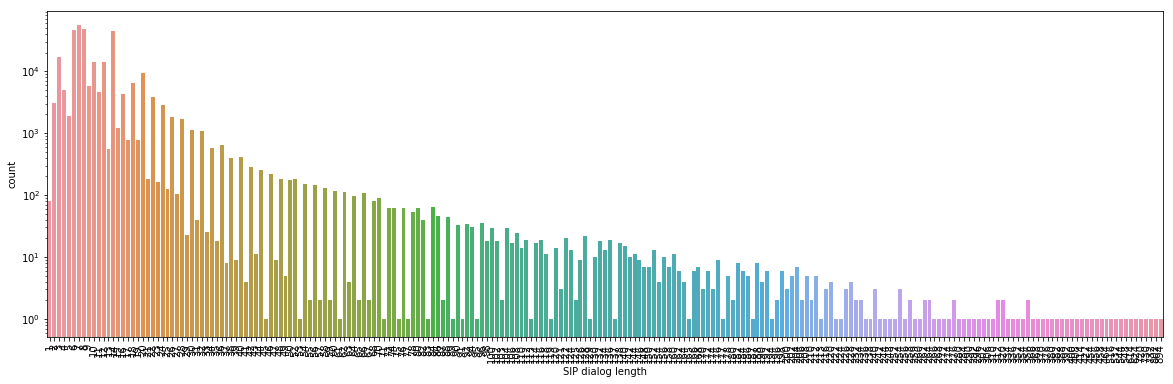

In [10]:
plot_data(df_dialog_len, 'SIP dialog length', 'log')

In [11]:
df_info_200OK = info_200OK_trans(sip_df)

In [12]:
df_info_rx_rrt = rx_info_tx_200OK_rrt(df_info_200OK)

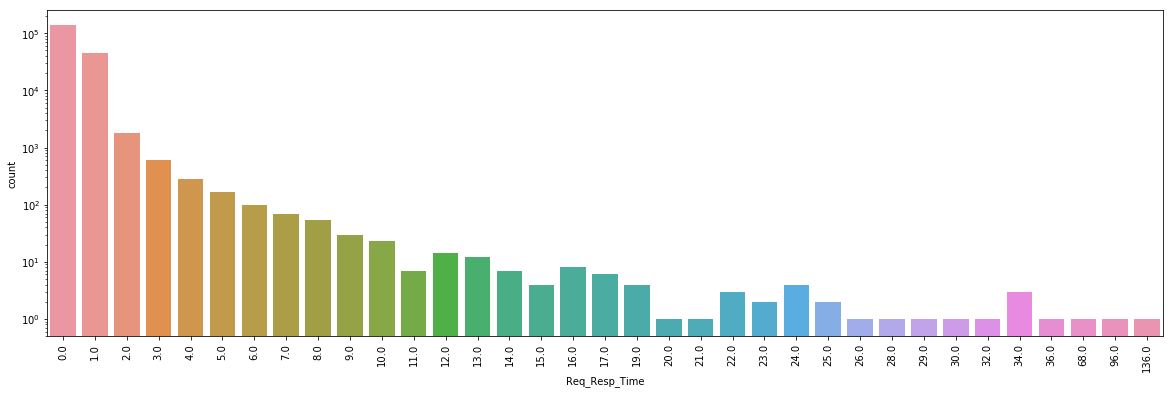

In [13]:
plot_data(df_info_rx_rrt, 'Req_Resp_Time', 'log')

In [14]:
df_info_200OK_rtr = retransmits_counter_tx(df_info_200OK, 'INFO')

In [15]:
df_info_200OK_tx = req_resp_time_tx(df_info_200OK, 'INFO-200OK')

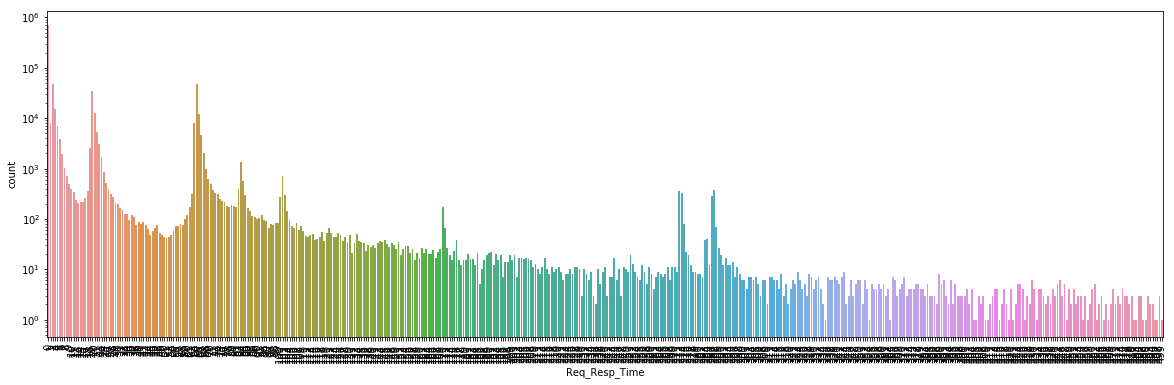

In [16]:
plot_data(df_info_200OK_tx[df_info_200OK_tx['Req_Resp_Time'] < 500], 'Req_Resp_Time', 'log')

In [17]:
df_invite_200OK = invite_200OK_trans(sip_df)

In [18]:
df_invite_200OK_rtr = retransmits_counter_tx(df_invite_200OK, 'INVITE')

In [19]:
df_invite_200OK_tx = req_resp_time_tx(df_invite_200OK, 'INVITE-200OK')

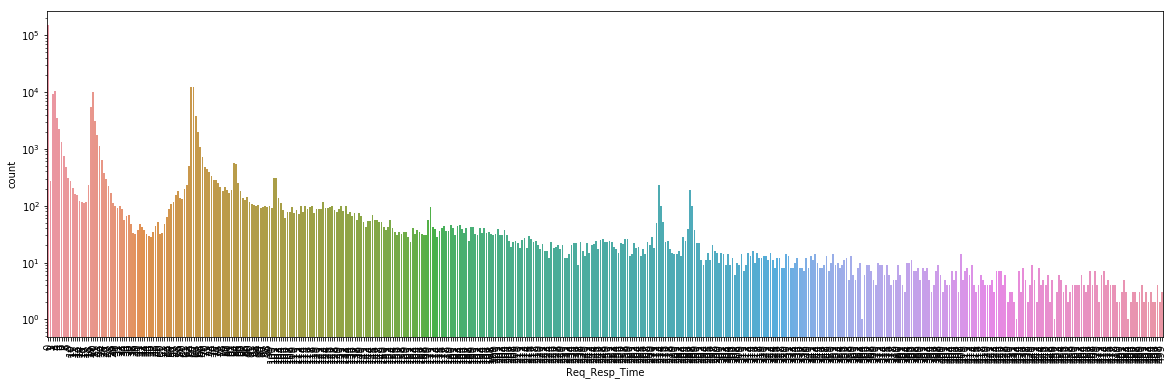

In [20]:
plot_data(df_invite_200OK_tx[df_invite_200OK_tx['Req_Resp_Time'] < 500], 'Req_Resp_Time', 'log')

In [21]:
retransmissions_percentage(df_info_200OK_rtr, df_info_200OK_no_rtr)

'0.28%'

In [22]:
retransmissions_percentage(df_invite_200OK_rtr, df_invite_200OK_no_rtr)

'0.76%'